# House Price Prediction - ML Model Comparison
This notebook performs EDA, preprocessing, and trains multiple regression models to compare their performance on house price prediction.

In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [3]:
# 📂 Load Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


## EDA

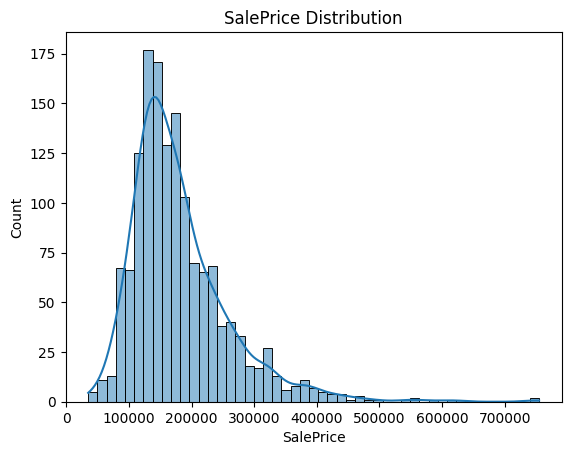

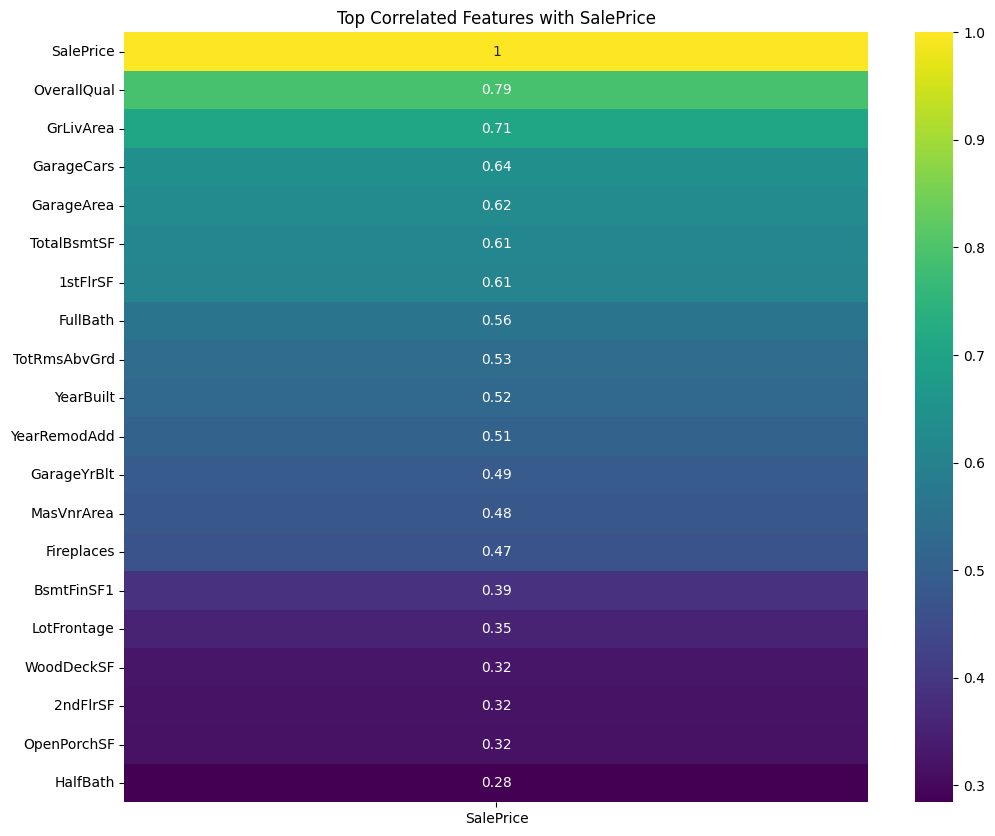

Missing values in Train set:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [4]:
# Target Variable Distribution
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).head(20).to_frame(), annot=True, cmap='viridis')
plt.title("Top Correlated Features with SalePrice")
plt.show()

# Missing values
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Missing values in Train set:\n", missing)

## Preprocessing & Feature Engineering

In [5]:
# Combine train and test
train_id = train['Id']
test_id = test['Id']
y = train['SalePrice']
train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

all_data = pd.concat([train, test], axis=0)

# Handle missing values
for col in all_data.select_dtypes(include='object').columns:
    all_data[col] = all_data[col].fillna("None")

for col in all_data.select_dtypes(exclude='object').columns:
    all_data[col] = all_data[col].fillna(all_data[col].median())

# Encode categorical variables
all_data = pd.get_dummies(all_data)

# Split back to train/test
X = all_data[:len(y)]
X_test = all_data[len(y):]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Train-Test Split for validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model Training & Evaluation

In [12]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore", category=ConvergenceWarning)

models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.01, max_iter=10000),
    "ElasticNet Regression": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "kNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf', C=100)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    results[name] = mae
    print(f"{name}: MAE = {mae:.2f}")

Linear Regression: MAE = 21112.28
Lasso Regression: MAE = 20839.90
ElasticNet Regression: MAE = 18255.60
Polynomial Regression: MAE = 23825.66
kNN Regressor: MAE = 24953.95
Decision Tree: MAE = 27593.75
Random Forest: MAE = 17871.04
SVR: MAE = 57237.21


## Model Comparison

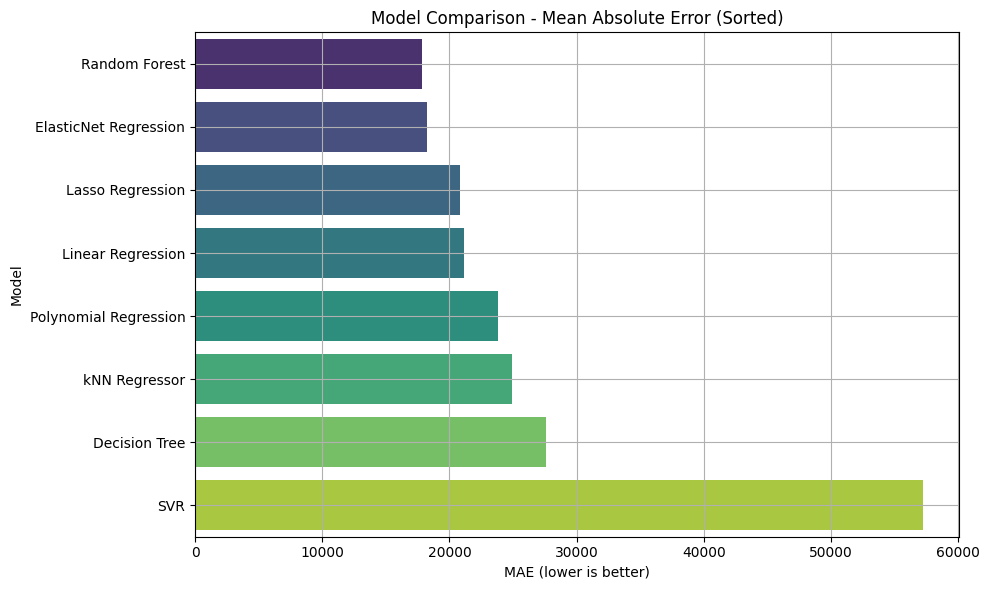

In [20]:
df_results = pd.DataFrame({
    "Model": list(results.keys()),
    "MAE": list(results.values())
}).sort_values("MAE")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="MAE", y="Model", hue="Model", palette="viridis", dodge=False, legend=False)
plt.title("Model Comparison - Mean Absolute Error (Sorted)")
plt.xlabel("MAE (lower is better)")
plt.ylabel("Model")
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Prediction (Random Forest)

In [21]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_scaled, y)
final_preds = best_model.predict(X_test_scaled)
submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": final_preds
})
submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")

Submission saved as submission.csv
